In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
project_dir = str(Path.cwd().parent)
if project_dir not in sys.path:
    sys.path.append(project_dir)
import src
from src import graphs, figures, vis, paths_and_constants

from pprint import pprint
import networkx as nx
import matplotlib.pyplot as plt
import rdkit
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
import rdkit.Chem.Descriptors
import seaborn as sns
import numpy as np
import matplotlib as mpl

Colors = src.paths_and_constants.Colors
_P = src.paths_and_constants.Paths

In [3]:
vis.set_visualization_style()

findfont: Font family ['FiraCode Nerd Font'] not found. Falling back to DejaVu Sans.


In [4]:
from dataclasses import dataclass
from dataclasses_json import dataclass_json
from networkx.readwrite import json_graph
import json
import pprint

In [5]:
@dataclass_json
@dataclass
class FeatureSpec:
    name: str
    data_type: str # continuos, binary, categorical
    dim: int
    values: list[str] | tuple[float, float]

    def is_discrete(self):
        return self.data_type == 'categorical'

@dataclass_json
@dataclass
class GraphSpec:
    nodes: list[FeatureSpec]
    edges: list[FeatureSpec]
    globals: list[FeatureSpec]
    nodes_are: str
    edges_are: str
    name: str
    short_name: str



def save_graph(g, spec, filename):
    with open(f'{filename}.json', 'w') as f:
        data = json_graph.node_link_data(g, edges="edges")
        data['spec'] = spec
        json.dump( data, f)

def load_graph(g, filename):
    with open(f'{filename}.json', 'r') as f:
        data = json.load(f)
        spec = GraphSpec.from_dict(data.pop('spec'))
        g = json_graph.node_link_graph(data, edges="edges")
    return g, spec

## Font biz

## Drawing utils

In [6]:
COLS = {"node": [0.9924814063556459, 0.7706828938471941, 0.13536173089925596], "edge": [0.29980485085029285, 0.6460124523743146, 0.8794108354242172], "global": [0.9882352941176471, 0.5529411764705883, 0.3843137254901961], "adj": [0.6509803921568628, 0.8470588235294118, 0.32941176470588235], "node-swatches": [[0.9924814063556457, 0.8199527509810332, 0.13536173089925607], [0.8734523326572009, 0.6881261150847054, 0.05439080459770096], [1.0, 0.8649716891002563, 0.3278431372549018], [0.6487843137254902, 0.5344925526608907, 0.07905882352941163], [1.0, 0.8680118244380879, 0.527843137254902], [0.44411629479377945, 0.38078912302353574, 0.08372684246112228], [0.9999999999999999, 0.941544746203253, 0.727843137254902], [0.25944827586206887, 0.18886908222305776, 0.0683948613928329], [1.0, 0.9854492317374898, 0.9278431372549019]], "edge-swatches": [[0.29980485085029296, 0.6198860301949669, 0.879410835424217], [0.19282659604126007, 0.5686906640831233, 0.78638909023325], [0.4393817489080941, 0.7300312172571489, 0.9398339373664159], [0.19240349409906143, 0.39949472982800394, 0.5868121921754486], [0.5989586469658955, 0.7830998858687428, 0.9802570393086146], [0.17198039215686278, 0.3314409960146927, 0.40723529411764714], [0.7792156862745102, 0.9278005924207813, 0.9999999999999999], [0.13155729021466414, 0.19256663694469078, 0.24765839605984583], [0.97921568627451, 0.9899189954186047, 1.0]], "global-swatches": [[0.9882352941176471, 0.5807242903174685, 0.38431372549019605], [0.9431127450980393, 0.501711391346249, 0.22943627450980386], [0.9999999999999999, 0.7378560510911416, 0.5725490196078432], [0.8570588235294119, 0.2898052461009251, 0.11549019607843125], [0.9999999999999999, 0.8510427150963003, 0.7725490196078434], [0.6421813725490195, 0.3313420675459361, 0.13036764705882353], [1.0, 0.9777528957450206, 0.9725490196078432], [0.4473039215686274, 0.23638083876229615, 0.12524509803921569], [1.0, 1.0, 1.0]], "adj-swatches": [[0.7095309631894509, 0.8470588235294119, 0.3294117647058823], [0.5388328831623432, 0.7463025210084033, 0.23016806722689087], [0.7846005866262733, 0.915378151260504, 0.4610924369747901], [0.404954955008016, 0.5546218487394958, 0.2218487394957983], [0.8150637408089185, 0.9636974789915965, 0.6127731092436978], [0.3162871773972231, 0.3829411764705882, 0.1935294117647059], [0.912808207540323, 0.9920168067226892, 0.784453781512605], [0.19848715911984285, 0.23126050420168068, 0.14521008403361343], [0.9938807059543996, 1.0, 0.9764705882352942]], "background": [0.93, 0.93, 0.93]}

def light_color_cmap(color, name='test'):
    start_color = (1,1,1)
    end_color = color
    colors = [start_color, end_color]
    cmap = mpl.colors.LinearSegmentedColormap.from_list(name, colors,
                                                        N=256)
    return cmap

def draw_tensor(values, col, labels=None, cmaps=None, rsize=0.5,
                rotate_text=True, draw_text=True):
    assert values.ndim ==2 , 'Olny 2D tensors!'
    n,k = values.shape
    if labels is None:
        labels = [str(i) for i in range(k)]
    if cmaps is None:
        cmaps = [light_color_cmap(col)]*k

    width, height = n*rsize, k*rsize
    fig, ax = plt.subplots(figsize=(width, height))
    for i in range(n):
        for j in range(k):
            pos = i*rsize, height-(j+1)*rsize
            color = cmaps[j](values[i, j])
            rect = plt.Rectangle(pos, rsize, rsize, facecolor=color)
            ax.add_patch(rect)

    # Set axis limits and labels
    ax.set_xlim(0, width)
    ax.set_ylim(0, height)
    ax.yaxis.tick_left()  # Move x-ticks to the top
    ax.set_xticks([])
    ax.set_xticklabels([])
    if draw_text:
        ax.set_yticks(np.arange(rsize/2, height, rsize))
        ax.set_yticklabels(labels[::-1])
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])

    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_edgecolor(col)  # Or any color you prefer
    return

def one_hot_encode(values, n_classes):
    n = len(values)
    k = n_classes
    m = np.zeros((n,k))
    row_indices = np.arange(n)
    m[row_indices, values] = 1.0
    return m

def normalize_values(x, vmin, vmax):
    return np.clip((x - vmin) / (vmax - vmin), 0, 1.0)

def cast_as_2d(x):
    x = np.array(x)
    if x.ndim == 0:
        return np.array([[x]])
    elif x.ndim == 1:
        return x.reshape(-1, 1)
    return x

def build_drawing_parts(g, spec_list, main_color, extra_colors, extract_fn):
    tensors = {}
    names = []
    cmaps = []
    n_colors = sum(feat.dim if feat.is_discrete() else 1 for feat in spec_list)
    pal = extra_colors[:n_colors]
    cmaps = [light_color_cmap(c) for c in pal]
    for i, feat in enumerate(spec_list):
        name = feat.name
        value_dict = extract_fn(g, name)
        first = i ==0
        if not value_dict:
            raise ValueError(f'No attribute {name} in graph')
        if feat.data_type == 'categorical':
            id_map = {v:i for i,v in enumerate(feat.values)}
            ids = [id_map[v] for v in value_dict.values()]
            tensor = one_hot_encode(ids, len(feat.values))
            tensors[name] = tensor
            names.extend(feat.values)
            if first:
                colors = [cmaps[i](1.0) for i in np.argmax(tensor, axis=1)]
        elif feat.data_type == 'continuous':
            if feat.dim == 1:
                tensor = cast_as_2d(list(value_dict.values()))
            else:
                tensor = np.hstack(list(value_dict.values()))
            tensors[name] = normalize_values(tensor, feat.values[0], feat.values[1])
            names.append(name)
            if first:
                colors = [cmaps[0](vi) for vi in tensor[:, 0]]
        else:
            raise ValueError(f'Unknown data type {feat.data_type}')

    full_tensor = np.hstack(list(tensors.values()))
    return full_tensor, names, colors, cmaps


def draw_graph_legend(G, name, node_name, edge_name, fontsize=22, linespacing=1.2):
    fig = plt.gcf()
    ax = plt.gca()
    bbox = ax.get_position()
    upper_left_x = bbox.x1
    upper_left_y = bbox.y1

    fig.text(bbox.x0, bbox.y1, name,
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=fontsize,
            transform=fig.transFigure)

    text1 = plt.text(upper_left_x, upper_left_y, f'{len(G.nodes):3d} nodes ({node_name})', fontsize = fontsize,
            horizontalalignment='right',
            verticalalignment='top',
            transform=fig.transFigure)

    # Get the height of a single line of text in figure coordinates
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()
    bbox_text = text1.get_window_extent(renderer=renderer) #use text1 instead of creating a new one
    text_height_pixels = bbox_text.height
    text_height_figure = text_height_pixels / fig.dpi / fig.get_size_inches()[1]
    second_line_y = upper_left_y - text_height_figure * linespacing

    # Second text
    ax.text(upper_left_x, second_line_y, f'{len(G.edges):3d} edges ({edge_name})',
            horizontalalignment='right',
            verticalalignment='top',
            transform=fig.transFigure,
            fontsize=fontsize)

sns.set_style("whitegrid", {'axes.grid' : False})
np.set_printoptions(precision=3)


def display_svg(svg_text):
    ipy_display.display(SVG(svg_text))

def set_visualization_style():
    mpl.rcParams["font.sans-serif"] = ['Fira Code']
    mpl.rcParams["savefig.dpi"] = 300
    mpl.rcParams["savefig.pad_inches"] = 0.1
    mpl.rcParams["savefig.transparent"] = True
    # mpl.rcParams['axes.linewidth'] = 2.5
    mpl.rcParams["legend.markerscale"] = 1.0
    mpl.rcParams["legend.fontsize"] = "small"
    # seaborn color palette
    sns.set_palette("colorblind")



def save_figure(name, adir='.'):
    fig = plt.gcf()
    for ext in ['svg', 'png']:
        path = Path(adir) / f'{name}.{ext}'
        fig.savefig(path, dpi=300, transparent = True, bbox_inches = 'tight', pad_inches = 0)


set_visualization_style()

# Graphs

## SMILES to graph

In [7]:
def mol_to_nx(mol, include_hydrogens=False):

    if include_hydrogens:
      mol = Chem.AddHs(mol)

    AllChem.Compute2DCoords(mol)
    Chem.rdPartialCharges.ComputeGasteigerCharges(mol)
    conformer = mol.GetConformer()

    G = nx.Graph()
    for atom in mol.GetAtoms():
        atom_idx = atom.GetIdx()
        pos = conformer.GetAtomPosition(atom_idx)
        G.add_node(atom.GetIdx(),
                   node_name = f'{atom_idx}:{atom.GetSymbol()}',
                   atomic_num=atom.GetAtomicNum(),
                   is_aromatic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol(),
                   pos=(pos.x, pos.y))

    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=str(bond.GetBondType()))
    G.graph['MW'] = round(Chem.Descriptors.MolWt(mol), 2)
    G.graph['LogP'] = round(rdkit.Chem.Crippen.MolLogP(mol),2)
    return G

In [8]:
# Glucose 6-phosphate
smiles = 'O[C@H]1[C@H](O)[C@@H](COP(O)(O)=O)OC(O)[C@@H]1O'
# ATP
#smiles = 'O=P(O)(O)OP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n2cnc1c(ncnc12)N)[C@H](O)[C@@H]3O'
mol = Chem.MolFromSmiles(smiles)
G = mol_to_nx(mol)

In [9]:
spec_dict = {
    'name':'Glucose 6-Phosphate',
    'short_name':'G6P',
    'nodes_are':'atoms',
    'edges_are':'bonds',
    'nodes': [{'name':'atom_symbol',
                   'data_type': 'categorical',
                   'dim': 3,
                   'values': ['C','O', 'P']},
                  ],
        'edges': [{'name': 'bond_type',
                   'data_type': 'categorical',
                   'dim': 2,
                   'values': ['SINGLE', 'DOUBLE']}],
        'globals': [{'name':'MW',
                   'data_type': 'continuous',
                     'dim':1,
                    'values': (200, 500)},
                    {'name':'LogP',
                   'data_type': 'continuous',
                     'dim':1,
                     'values': (-1.0, 1.0)
                    },
        ]
}
spec = GraphSpec.from_dict(spec_dict)
fname = _P.data_dir / f'{spec.short_name}_graph.json'
new_spec = graphs.GraphSpec.from_dict(spec_dict)
graphs.save_as_json(G, new_spec, fname)
G, spec = graphs.load_from_json(G, fname)
pprint.pprint(spec)

GraphSpec(nodes=[FeatureSpec(name='atom_symbol',
                             data_type='categorical',
                             dim=3,
                             values=['C', 'O', 'P'])],
          edges=[FeatureSpec(name='bond_type',
                             data_type='categorical',
                             dim=2,
                             values=['SINGLE', 'DOUBLE'])],
          globals=[FeatureSpec(name='MW',
                               data_type='continuous',
                               dim=1,
                               values=[200, 500]),
                   FeatureSpec(name='LogP',
                               data_type='continuous',
                               dim=1,
                               values=[-1.0, 1.0])],
          nodes_are='atoms',
          edges_are='bonds',
          name='Glucose 6-Phosphate',
          short_name='G6P')


Compute drawing components & information

In [10]:
loaded_spec = new_spec
name = loaded_spec.name
short_name = loaded_spec.short_name
node_col = Colors.node
edge_col = Colors.edge
global_col = Colors.globals
node_tensor, node_labels, node_colors, node_cmaps = figures.build_graph_parts(G,
                                                    loaded_spec.nodes,
                                                    node_col,
                                                    Colors.node_swatches,
                                                    nx.get_node_attributes)
edge_tensor, edge_labels, edge_colors, edge_cmaps = figures.build_graph_parts(G,
                                                    loaded_spec.edges,
                                                    edge_col,
                                                    Colors.edge_swatches,
                                                    nx.get_edge_attributes)
global_tensor, global_labels, global_colors, global_cmaps = figures.build_graph_parts(G,
                                                    loaded_spec.globals,
                                                    global_col,
                                                    Colors.globals_swatches,
                                                    lambda x, key: {0:x.graph[key]})
node_tensor, node_labels, node_cmaps
edge_tensor, edge_labels, edge_cmaps
global_tensor, global_labels, global_cmaps

(array([[0.2, 0. ]]),
 ['MW', 'LogP'],
  <matplotlib.colors.LinearSegmentedColormap at 0x1d393fc1e50>])

findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic f

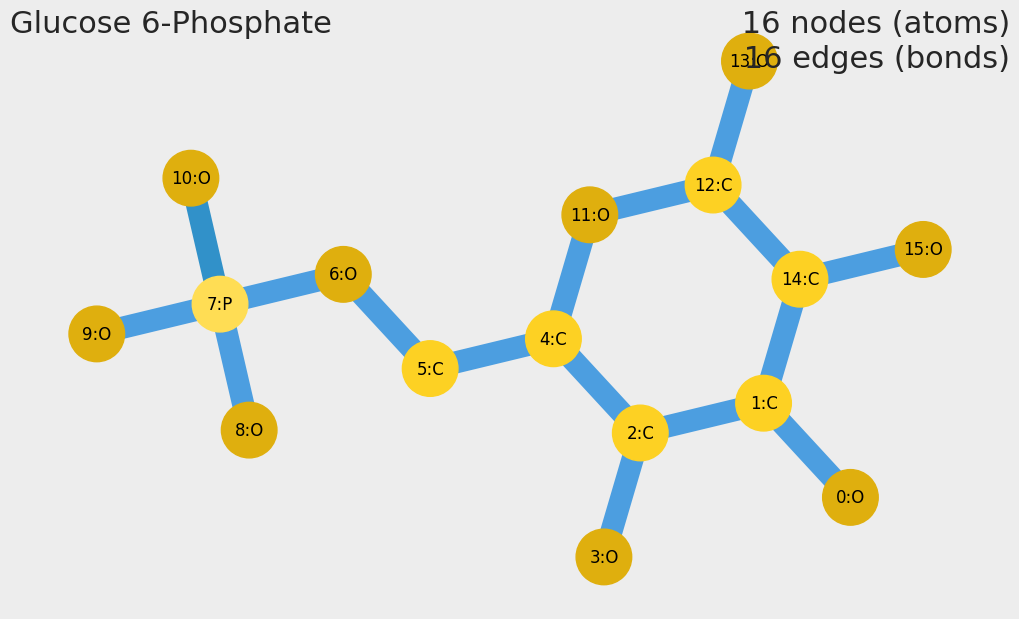

In [11]:
fig = plt.figure(figsize=(10, 6))
nx.draw(G,
        labels = nx.get_node_attributes(G, 'node_name'),
        node_color = node_colors,
        edge_color = edge_colors,
        width = 16,
        pos = nx.get_node_attributes(G, 'pos'),
        with_labels = True,
        node_size=1600)
fig.set_facecolor(Colors.background)
figures.draw_graph_legend(G, name, loaded_spec.nodes_are, loaded_spec.edges_are)
vis.save_figure(_P.assets_dir/ f'{short_name}_graph')
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic f

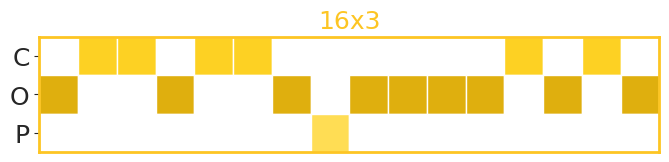

findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code


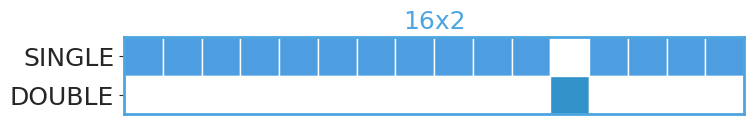

findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code


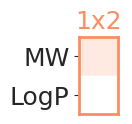

findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fira Code
findfont: Generic f

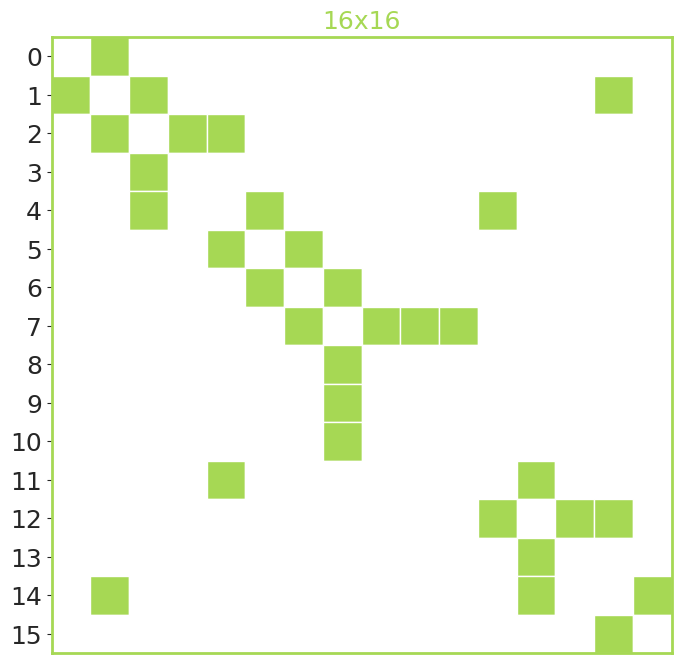

In [27]:
figures.draw_tensor(node_tensor, node_col, node_labels, node_cmaps, .5)
vis.save_figure(_P.assets_dir/f'{short_name}_node_tensor')
figures.draw_tensor(edge_tensor, edge_col, edge_labels, edge_cmaps, .5)
vis.save_figure(_P.assets_dir/f'{short_name}_edge_tensor')
figures.draw_tensor(global_tensor, global_col, global_labels, global_cmaps, .5)
vis.save_figure(_P.assets_dir/f'{short_name}_global_tensor')
adj = nx.to_numpy_array(G)
adj_index =  [f'{i}' for i in range(adj.shape[0])]
figures.draw_tensor(adj, Colors.adj, adj_index, draw_text=True)
vis.save_figure(_P.assets_dir/f'{short_name}_adj')

## Native RDkit drawings

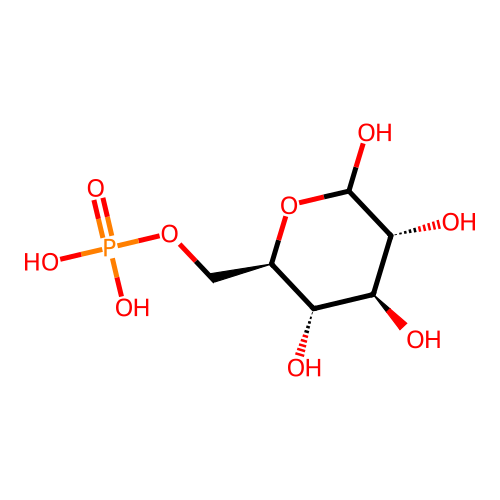

In [28]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Draw

smi = 'O[C@H]1[C@H](O)[C@@H](COP(O)(O)=O)OC(O)[C@@H]1O'

mol = Chem.MolFromSmiles(smi)
drawer = rdMolDraw2D.MolDraw2DSVG(500, 500) # or MolDraw2DCairo to get PNGs
opts = drawer.drawOptions()
opts.bgColor = None
opts.clearBackground = False
opts.bondLineWidth = 5
drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg = drawer.GetDrawingText()
vis.display_svg(svg)
with open(_P.assets_dir / 'G6p_mol.svg', 'w') as afile:
    afile.write(svg)
